In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
# training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
train_size = int(0.8 * len(training_set))
test_size = len(training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
from torchsummary import summary
model = torchvision.models.googlenet().to('cuda')
summary(model, (3, 224, 224))

/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
for layer_name, layer in model.named_modules():
    print(layer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()

        self.branch_A = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.branch_B = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.branch_C = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.branch_D = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

    def forward(self, x):
        branch_A = self.branch_A(x)
        branch_B = self.branch_B(x)
        branch_C = self.branch_C(x)
        branch_D = self.branch_D(x)
        x_out = torch.cat([branch_A, branch_B, branch_C, branch_D], 1)
        return x_out

class SENet(nn.Module):
    def __init__(self, in_channel, reduction_ratio):
        super(SENet, self).__init__()
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_features=in_channel, out_features=round(in_channel/reduction_ratio))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_features=round(in_channel/reduction_ratio), out_features=in_channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.globalAvgPool(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * x
        return out

class pretrainedmodel(nn.Module):
    def __init__(self):
        super(pretrainedmodel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )


        self.inception = InceptionBlock(64)
        self.inception2 = InceptionBlock(256)

        self.inception3 = InceptionBlock(256)
        self.inception4 = InceptionBlock(256)

        self.pool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(4096, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 101)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.SEBlock = SENet(in_channel=256, reduction_ratio=16)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        x = self.inception(x)

        x = self.inception2(x)

        x = self.inception3(x)

        x = self.inception4(x)

        x = self.SEBlock(x)

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Model init
model = pretrainedmodel().to(device)
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         AvgPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5          [-1, 128, 53, 53]          73,856
       BatchNorm2d-6          [-1, 128, 53, 53]             256
              ReLU-7          [-1, 128, 53, 53]               0
         AvgPool2d-8          [-1, 128, 26, 26]               0
            Conv2d-9          [-1, 256, 24, 24]         295,168
      BatchNorm2d-10          [-1, 256, 24, 24]             512
             ReLU-11          [-1, 256, 24, 24]               0
        AvgPool2d-12          [-1, 256, 11, 11]               0
           Conv2d-13             [-1, 64, 9, 9]         147,520
      BatchNorm2d-14             [-1, 6

In [ ]:
epoch_number = 0

EPOCHS = 10
path_save_cp = '/home/crueang/Chaks/AIOT/4_1/cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel_caltech101.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 1.44695 train acc 0.62873 validate loss 1.79916 validate acc 0.57546
--------------------------------------------------------------------------------
Epochs 2   train loss 1.24030 train acc 0.67642 validate loss 1.79699 validate acc 0.56452
--------------------------------------------------------------------------------
Epochs 3   train loss 1.04466 train acc 0.71848 validate loss 1.78454 validate acc 0.57546
--------------------------------------------------------------------------------
Epochs 4   train loss 0.86469 train acc 0.76646 validate loss 1.69410 validate acc 0.61002
--------------------------------------------------------------------------------
Epochs 5   train loss 0.70828 train acc 0.80032 validate loss 1.85545 validate acc 0.58871
--------------------------------------------------------------------------------
Epochs 6   train loss 0.55324 train acc 0.83864 validate loss 1.89147 validate acc 0.59793
-------------------------------------------------

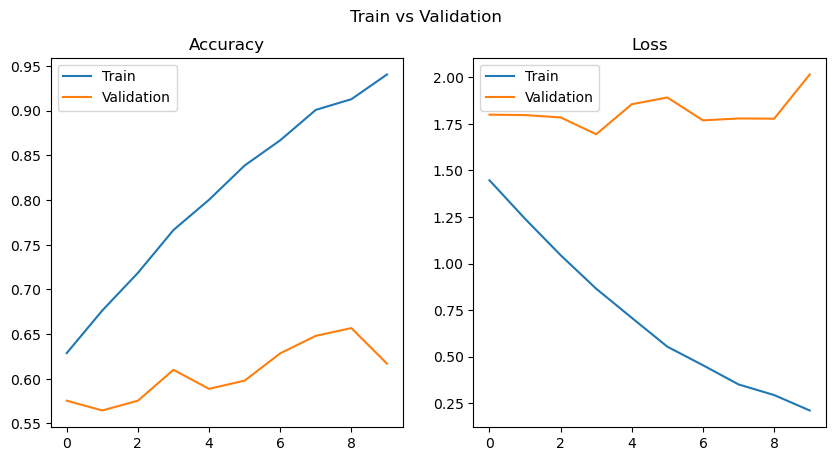

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = '/home/crueang/Chaks/AIOT/4_1/cp/best_pretrainedmodel_caltech101.pth'

device = 'cpu'

loaded_model = pretrainedmodel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss

    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

/tmp/ipykernel_2778245/4153287180.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 1.6940035820007324] [accuracy_test: 60.95 %]


Change new head and some FC layers

In [ ]:
transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.SVHN('./data', split='train', transform=transform, download=True)
# validation_set = torchvision.datasets.SVHN('./data', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.QMNIST('./data', what='train', transform=transform, download=True)
# validation_set = torchvision.datasets.QMNIST('./data', what='test10k', transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.STL10('./data', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.STL10('./data', split='test', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 2640397119/2640397119 [05:00<00:00, 8775661.50it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Training set has 5000 instances
Validation set has 8000 instances


In [ ]:
# Model init
device = 'cuda'
new_model_head = pretrainedmodel().to(device)
#---load and replace new hidden layers---
checkpoint = torch.load('/home/crueang/Chaks/AIOT/4_1/cp/best_pretrainedmodel_caltech101.pth', weights_only=True)
new_model_head.load_state_dict(checkpoint, strict=False)
new_model_head.fc2 = nn.Linear(2048, 1024).to(device)
new_model_head.fc3 = nn.Linear(1024, 10).to(device)
#---------------------------------------
summary(new_model_head, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(new_model_head.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         AvgPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5          [-1, 128, 53, 53]          73,856
       BatchNorm2d-6          [-1, 128, 53, 53]             256
              ReLU-7          [-1, 128, 53, 53]               0
         AvgPool2d-8          [-1, 128, 26, 26]               0
            Conv2d-9          [-1, 256, 24, 24]         295,168
      BatchNorm2d-10          [-1, 256, 24, 24]             512
             ReLU-11          [-1, 256, 24, 24]               0
        AvgPool2d-12          [-1, 256, 11, 11]               0
           Conv2d-13             [-1, 64, 9, 9]         147,520
      BatchNorm2d-14             [-1, 6

In [ ]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(new_model_head.state_dict(), path_save_cp+'best_resumemodel1.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 1.60107 train acc 0.41340 validate loss 1.33068 validate acc 0.51950
--------------------------------------------------------------------------------
Epochs 2   train loss 1.19730 train acc 0.56660 validate loss 1.25645 validate acc 0.54587
--------------------------------------------------------------------------------
Epochs 3   train loss 0.98939 train acc 0.64080 validate loss 1.15670 validate acc 0.59437
--------------------------------------------------------------------------------
Epochs 4   train loss 0.81982 train acc 0.71080 validate loss 1.19646 validate acc 0.59250
--------------------------------------------------------------------------------
Epochs 5   train loss 0.68000 train acc 0.75340 validate loss 1.29520 validate acc 0.59200
--------------------------------------------------------------------------------
Time consumption for accelerated CUDA training (device:cuda): 127.15855598449707 sec


In [ ]:
# Inference phase
device = 'cpu'
PATH = '/home/crueang/jira/cp/best_resumemodel1.pth'
loaded_resume_model = pretrainedmodel()
loaded_resume_model.fc2 = nn.Linear(2048, 1024).to(device)
loaded_resume_model.fc3 = nn.Linear(1024, 10).to(device)
loaded_resume_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_resume_model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_resume_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(resume training || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

/tmp/ipykernel_2778245/1406218986.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_resume_model.load_state_dict(torch.load(PATH))


[(resume training || test loss: 1.1566966772079468] [accuracy_test: 59.440000000000005 %]


#### Additional Quantitative Matrics

In [ ]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

Precision/Recall/F-beta score: (0.6132790229141166, 0.594375, 0.5913100265666492, None)
NMI score: 0.41514212691015356, RI score: 0.3380989756244577


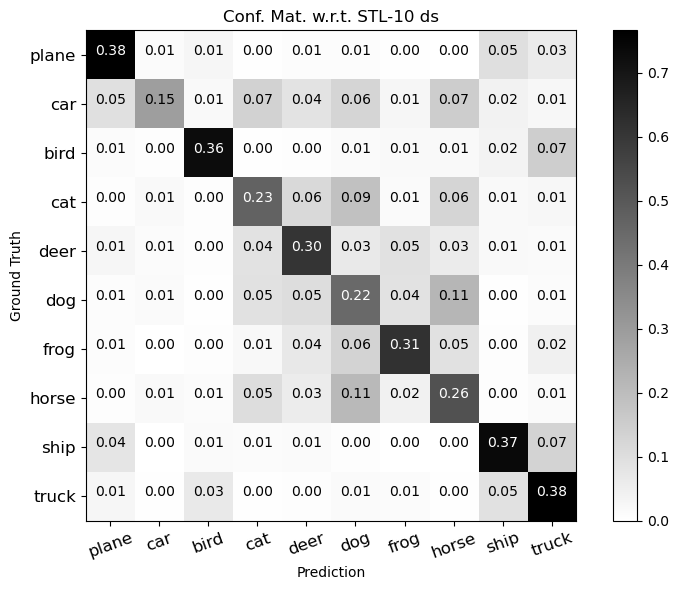

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. STL-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")